In [1]:
import re
import pandas as pd
import openpyxl
from easydict import EasyDict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

In [2]:
# -- option 설정
_STORE_OPTION = 'codishop'
_SORT_OPTION = 'view'

In [6]:
def get_item_data(file_name: str, preprocess_type:str='raw') -> pd.DataFrame:
    ITEM_PATH = f'/opt/ml/input/data/{preprocess_type}_{_STORE_OPTION}/{_SORT_OPTION}/item/'
    return pd.read_excel(f'{ITEM_PATH}{file_name}.xlsx', engine='openpyxl')

def get_codi_data(file_name: str,  preprocess_type:str='raw') -> pd.DataFrame:
    CODI_PATH = f'/opt/ml/input/data/{preprocess_type}_{_STORE_OPTION}/{_SORT_OPTION}/codi/'
    return pd.read_excel(f'{CODI_PATH}{file_name}.xlsx', engine='openpyxl')

In [8]:
# -- item 데이터 받아오기
item = pd.read_excel('/opt/ml/input/data/asset_codishop/view/item/item.xlsx', engine='openpyxl')
item_tag = get_item_data('item_tag')
item_fit = get_item_data('item_fit')
item_buy_age = get_item_data('item_buy_age')
item_buy_gender = get_item_data('item_buy_gender')
item_four_season = get_item_data('item_four_season')
item_option1 = get_item_data('item_option1')
item_option2 = get_item_data('item_option2')
item_option3 = get_item_data('item_option3')
item_rel_codi_url = get_item_data('item_rel_codi_url')

# -- codi 데이터 받아오기
codi = get_codi_data('codi')
codi_tag = get_codi_data('codi_tag')
coodi_item_id = get_codi_data('codi_item_id')

In [9]:
item.head()

,id,name,big_class,mid_class,brand,serial_number,gender,season,cum_sale,view,...,rating,price,url,img_url,R,G,B,season_day,most_bought_age_class,men_bought_ratio
0,969580,Denim Trucker Jacket Grey,아우터,트러커 재킷,THISISNEVERTHAT,TN2238,남,S/S,NaN,300.0,...,4.6,128000,https://www.musinsa.com/app/goods/969580/0,https://image.msscdn.net/images/goods_img/2019...,206,209,216,2019.0,1,94
1,1110028,레이아웃 로고 맨투맨 멜란지 그레이,상의,맨투맨/스웨트셔츠,COVERNAT,CO0000CR04GR,유니섹스,ALL,1400.0,11000.0,...,4.7,59000,https://www.musinsa.com/app/goods/1110028/0,https://image.msscdn.net/images/goods_img/2019...,173,178,174,NaN,0,47
2,986708,와이드 데님 팬츠 (BLEACH),바지,데님 팬츠,TOFFEE,TAS-WDDP05,남,ALL,25000.0,110000.0,...,4.8,49000,https://www.musinsa.com/app/goods/986708/0,https://image.msscdn.net/images/goods_img/2019...,146,167,186,2021.0,0,87
3,1112798,CORDURA® 1000D Nylon Traveler Backpack Grey,가방,백팩,THISISNEVERTHAT,TN2527,남,ALL,NaN,700.0,...,4.6,119000,https://www.musinsa.com/app/goods/1112798/0,https://image.msscdn.net/images/goods_img/2019...,48,50,48,2019.0,0,49
4,104238,올드스쿨 - 블랙 / VN000D3HY281,신발,캔버스/단화,VANS,VN000D3HY281,유니섹스,ALL,77000.0,23000.0,...,4.9,79000,https://www.musinsa.com/app/goods/104238/0,https://image.msscdn.net/images/goods_img/2014...,229,230,232,NaN,0,57


# 성별 전처리

In [60]:
item['gender'].unique()

array(['남', '남 여', '여'], dtype=object)

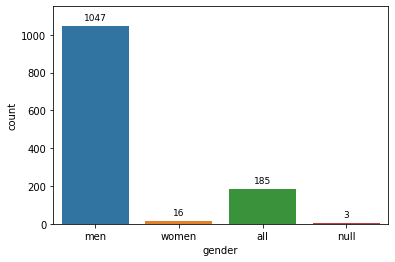

In [6]:
temp = item.copy()
temp.gender.fillna('null', inplace=True)

ax = sns.countplot(x='gender', data=temp, order=['남', '여', '남 여', 'null'])
ax.set_xticklabels(['men', 'women', 'all', 'null'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 9)
ax.set_ylim(0, 1150)
plt.ylabel('count')
plt.show()

1. [Issue] gender가 nan값인 아이템이 존재 -> 마스크, 우산, 카메라 등으로 남녀 상관 없이 사용할 수 있는 악세사리 아이템 
2. [Issue] 남 여 모두 입을 수 있는 제품이 존재 -> 카테고리 유지할 것인지 or 새로운 카테고리명으로 정의할 것인지?
3. [EDA] 여성 제품이 사용된 남성 코디가 존재: 약 16개

In [7]:
def preprocessing_gender_info(gender_info):
    '''
    성병 정보 추출 및 변환
    : gender_info - 하나의 아이템에 대한 gener 정보 (str or nan)
    '''
    if type(gender_info) == str:
        if gender_info != '남 여': return gender_info
    return '유니섹스'

# -- gender 데이터 전처리
item['gender'] = item.gender.transform(preprocessing_gender_info)
item['gender'].unique()

array(['남', '유니섹스', '여'], dtype=object)

# 사계절

In [65]:
item_four_season.head()

,id,four_season
0,1110028,봄
1,1110028,가을
2,952064,봄
3,952064,가을
4,952064,겨울


In [66]:
item_four_season['four_season'].unique()

array(['봄', '가을', '겨울', '여름'], dtype=object)

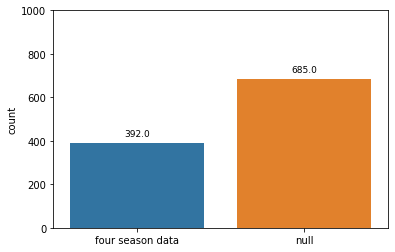

In [67]:
four_season_data = len(item_four_season['id'].unique())
ax = sns.barplot(x=['four season data', 'null'], y=[four_season_data, len(item)-four_season_data])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 9)
ax.set_ylim(0, 1000)
plt.ylabel('count')
plt.show()

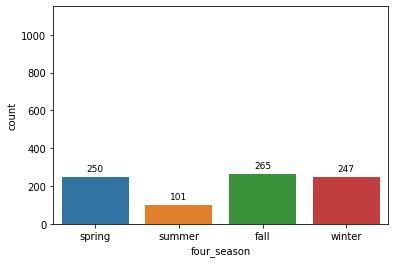

In [13]:
ax = sns.countplot(x='four_season', data=item_four_season, order=['봄', '여름', '가을', '겨울'])
ax.set_xticklabels(['spring', 'summer', 'fall', 'winter'])

# -- count plot 출력
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 9)
ax.set_ylim(0, 1150)
plt.ylabel('count')
plt.show()

1. 여름을 제외한 나머지 계절의 상품은 균등하게 크롤링 된 것을 알 수 있다

# 시즌

In [68]:
item['season'].unique()

array(['2019 S/S', 'ALL ALL', '2021 ALL', '2019 ALL', 'ALL', nan,
       '2022 S/S', '2021 S/S', '2019 F/W', '2020 S/S', 'ALL F/W',
       '2021 F/W', '2020 F/W', '2020 ALL', '2018 S/S', '2022 ALL',
       '2016 F/W', '2018 F/W', '2016 S/S', '2018 ALL', 'ALL S/S',
       '2017 F/W', '2017 S/S', '2016 ALL', '2022 F/W', '2022'],
      dtype=object)

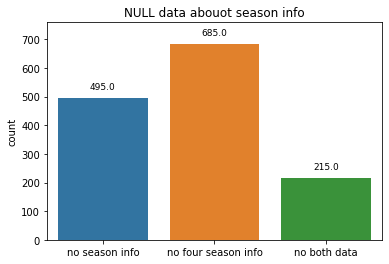

In [105]:
# -- bar plot 출력
no_season_info = set(item[item['season'].isnull()]['id'])
no_four_season_info = set(item['id']) - set(item_four_season['id'].unique())
no_both_info = no_season_info & no_four_season_info

plt.title('NULL data abouot season info')
ax = sns.barplot(x=['no season info', 'no four season info', 'no both data'], 
                 y=[len(no_season_info), len(no_four_season_info), len(no_both_info)])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 9)
ax.set_ylim(0, ax.get_ylim()[1]+40)
plt.ylabel('count')
plt.show()

In [70]:
big_class_list = []
for id in no_both_info:
    cs = item[item['id']==id]['big_class'].item()
    big_class_list.append(cs)

Counter(big_class_list)

Counter({'바지': 50, '모자': 17, '가방': 18, '신발': 73, '아우터': 23, '상의': 34})

### season_day feature 생성

In [71]:
def make_season_day(season_info):
    '''
    season 정보를 사용하여 season day 추출 및 생성
    : season_info - 하나의 item에 대한 season 정보 (str or nan)
    '''
    if type(season_info) == str:
        day = re.search('[0-9]{4}', season_info)
        if day: return int(day.group())
    return None


# -- season_day feature 생성
item['season_day'] = item.season.transform(make_season_day)
#item['season_day'].unique()

array([2019.,   nan, 2021., 2022., 2020., 2018., 2016., 2017.])

In [72]:
def preprosessing_season_info(season_info):
    '''
    season_info에서 S/S, F/W, ALL 정보 추출 및 변환
    : season_info - 하나의 item에 대한 season 정보 (str or nan)
    '''
    if type(season_info) == str:
        if re.search('[A-Z]\/[A-Z]', season_info): # S/S format의 str이 있는 경우 해당 정보를 뽑아냄
            return re.search('[A-Z]\/[A-Z]', season_info).group()
        elif re.search('[A-Z]{3}', season_info):   # ALL인 경우 해당 정보를 뽑아냄
            return re.search('[A-Z]{3}', season_info).group()
    return None

# -- season 데이터 전처리
item['season'] = item.season.transform(preprosessing_season_info)
# item['season'].unique()

array(['S/S', 'ALL', None, 'F/W'], dtype=object)

In [8]:
def transform_season_to_four_season(item: pd.DataFrame, item_four_season: pd.DataFrame) -> pd.DataFrame:
    '''
    season 정보를 사용해서 four_season 정보에 추가
    '''
    new_item = pd.merge(item, item_four_season, how='left')
    only_season = new_item[(new_item['season'].notnull()) & (new_item['four_season'].isnull())]
    four_season_list = []

    for item_id, season_info in tqdm(zip(only_season['id'], only_season['season'])):
        if season_info == 'S/S':
            four_season_list.append([item_id, '봄'])
            four_season_list.append([item_id, '여름'])
        elif season_info == 'F/W':
            four_season_list.append([item_id, '가을'])
            four_season_list.append([item_id, '겨울'])
        else: # ALL
            four_season_list.append([item_id, '사계절'])

    appended_item_four_season = pd.DataFrame(four_season_list, columns=['id', 'four_season'])
    updated_item_four_season = pd.concat([item_four_season, appended_item_four_season], ignore_index=True)
    return updated_item_four_season.drop_duplicates().reset_index(drop=True)


def preprocessing_null_season_data(item: pd.DataFrame, item_four_season:pd.DataFrame) -> pd.DataFrame:
    '''
    item의 season 정보와 four_season 정보가 모두 없는 결측지 데이터 전처리
    '''
    new_item = pd.merge(item, item_four_season, how='left')
    no_both_season = new_item[(new_item['season'].isnull()) & (new_item['four_season'].isnull())]
    four_season_list = []

    for item_id in tqdm(no_both_season['id']):
        four_season_list.append([item_id, '사게졀']) 

    appended_item_four_season = pd.DataFrame(four_season_list, columns=['id', 'four_season'])
    updated_item_four_season = pd.concat([item_four_season, appended_item_four_season], ignore_index=True)
    return updated_item_four_season.drop_duplicates().reset_index(drop=True)


# -- 데이터 초기화 (나중에 제거)
item = get_item_data('item')
item_four_season = get_item_data('item_four_season')

# -- four season 데이터 전처리
item_four_season = transform_season_to_four_season(item, item_four_season)
item_four_season = preprocessing_null_season_data(item, item_four_season)

588it [00:00, 652965.52it/s]
100%|██████████| 271/271 [00:00<00:00, 7188.16it/s]


# 체형

In [55]:
def synchronize_with_item(item:pd.DataFrame, raw_data: pd.DataFrame) -> pd.DataFrame:
    item_ids = item['id'].unique()
    new_data_list = []

    for item_id in tqdm(item_ids):
        data = raw_data[raw_data['id']==item_id].values.tolist()
        if data:
            new_data_list.extend(data)

    return pd.DataFrame(new_data_list, columns=raw_data.columns)

In [56]:
item_fit = synchronize_with_item(item, item_fit)
item_fit.head()

100%|██████████| 1077/1077 [00:00<00:00, 2366.28it/s]


,id,fit
0,1110028,루즈
1,952064,루즈
2,952064,오버 사이즈
3,1283757,오버 사이즈
4,1222009,레귤러


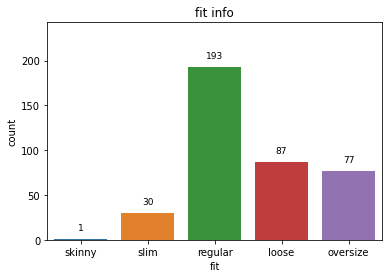

In [57]:
plt.title('fit info')
ax = sns.countplot(x='fit', data=item_fit, order=['스키니', '슬림', '레귤러', '루즈', '오버 사이즈'])
ax.set_xticklabels(['skinny', 'slim', 'regular', 'loose', 'oversize'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 10, height, ha = 'center', size = 9)
ax.set_ylim(0, ax.get_ylim()[1]+40)
plt.ylabel('count')
plt.show()

In [58]:
def make_item_fit_from_tag(item_tag:pd.DataFrame) -> pd.DataFrame:
    '''
    item의 tag에서 fit 정보를 추출
    reuturn 값 - [id, fit_from_tag] dataframe
    '''
    fit_list = ["핏", "와이드", "오버", "슬림", "레귤러", "스키니", "루즈", "릴렉스", "퍼팩트", "스트레이트", "캐롯핏", "코어", "벌룬"]
    tag_fit_list = list()

    for id, tag in zip(item_tag['id'], item_tag['tag']) :
        for fit in fit_list :
            if fit in tag : tag_fit_list.append((id, tag))

    item_fit_from_tag = pd.DataFrame(tag_fit_list, columns=["id","fit_from_tag"])
    remove_carryover = item_fit_from_tag[item_fit_from_tag["fit_from_tag"]=="캐리오버"].index
    remove_corefit = item_fit_from_tag[item_fit_from_tag["fit_from_tag"]=="코어핏"].index
    item_fit_from_tag.drop(remove_carryover, inplace=True)
    item_fit_from_tag.drop(remove_corefit, inplace=True)

    for idx in item_fit_from_tag.index:
        tag = item_fit_from_tag.loc[idx,'fit_from_tag']
        for fit in fit_list[1:]:
            if fit not in tag: continue
            if fit == "캐롯핏":
                item_fit_from_tag.loc[idx,'fit_from_tag'] = "슬림"
            elif fit in ["퍼팩트", "스탠다드핏", "스트레이트"]:
                item_fit_from_tag.loc[idx,'fit_from_tag'] = "레귤러"
            elif fit in ["벌룬", "오버"]:
                item_fit_from_tag.loc[idx,'fit_from_tag'] = "오버 사이즈"
            elif  fit == "릴렉스":
                item_fit_from_tag.loc[idx,'fit_from_tag'] = "루즈"
            else:
                item_fit_from_tag.loc[idx,'fit_from_tag'] = fit

    return item_fit_from_tag.drop_duplicates().reset_index(drop=True)

In [59]:
def transform_fit_from_tag_to_fit(item:pd.DataFrame, item_fit:pd.DataFrame, item_fit_from_tag: pd.DataFrame) -> pd.DataFrame:
    '''
    tag에 있는 fit 정보를 사용해서 fit에 데이터 추가
    : item_fit_from_tag [id, fit_from_tag] - tag에 있는 fit 정보가 담겨 있는 데이터프레임
    '''
    new_item = pd.merge(item, item_fit, how='left', on='id')
    new_item = pd.merge(new_item, item_fit_from_tag, how='left', on='id')
    only_fit_from_tag = new_item[(new_item['fit'].isnull()) & (new_item['fit_from_tag'].notnull())]
    id_fit_list = []

    for id, tag in tqdm(zip(only_fit_from_tag['id'], only_fit_from_tag['fit_from_tag'])):
        if tag == '오버': id_fit_list.append([id, '오버 사이즈'])
        else: id_fit_list.append([id, tag])

    appended_item_fit = pd.DataFrame(id_fit_list, columns=['id', 'fit'])
    updated_item_fit = pd.concat([item_fit, appended_item_fit], ignore_index=True)
    return updated_item_fit.drop_duplicates().reset_index(drop=True)


def preprocessing_null_fit_data(item:pd.DataFrame, item_fit:pd.DataFrame, item_fit_from_tag: pd.DataFrame) -> pd.DataFrame:
    '''
    item의 fit 정보와 fit_from_tag 정보가 모두 없는 결측지 데이터 전처리
    : item_fit_from_tag [id, fit_from_tag] - tag에 있는 fit 정보가 담겨 있는 데이터프레임
    '''
    new_item = pd.merge(item, item_fit, how='left', on='id')
    new_item = pd.merge(new_item, item_fit_from_tag, how='left', on='id')
    no_both_fit = new_item[(new_item['fit'].isnull()) & (new_item['fit_from_tag'].isnull())]
    id_fit_list = []
    
    for item_id in tqdm(no_both_fit['id']):
        id_fit_list.append([item_id, '프리'])

    appended_item_fit = pd.DataFrame(id_fit_list, columns=['id', 'fit'])
    updated_item_fit = pd.concat([item_fit, appended_item_fit], ignore_index=True)
    return updated_item_fit.drop_duplicates().reset_index(drop=True)

# -- 데이터 초기화 (나중에 제거)
item = pd.read_excel('/opt/ml/input/data/asset_codishop/view/item/item.xlsx', engine='openpyxl')
item_fit = get_item_data(file_name='item_fit')

# -- fit 데이터 전처리
item_fit_from_tag = make_item_fit_from_tag(item_tag=item_tag)
item_fit = transform_fit_from_tag_to_fit(item, item_fit, item_fit_from_tag)
item_fit = preprocessing_null_fit_data(item, item_fit, item_fit_from_tag)

186it [00:00, 662258.53it/s]
100%|██████████| 554/554 [00:00<00:00, 969801.51it/s]


In [60]:
item_fit['fit'].unique()

array(['루즈', '오버 사이즈', '레귤러', '슬림', '스키니', '와이드', '스탠다드핏', '프리'],
      dtype=object)

186it [00:00, 657237.19it/s]
100%|██████████| 554/554 [00:00<00:00, 880835.64it/s]


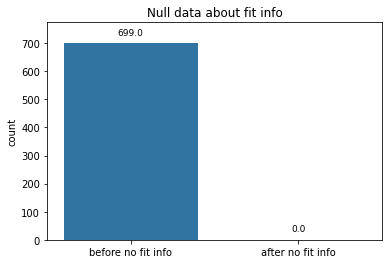

In [61]:
# -- bar plot 출력
plt.title('Null data about fit info')
item_fit = get_item_data('item_fit')
before_no_item_fit = set(item['id']) - set(item_fit['id'].unique())
item_fit = transform_fit_from_tag_to_fit(item, item_fit, item_fit_from_tag)
item_fit = preprocessing_null_fit_data(item, item_fit, item_fit_from_tag)
after_no_item_fit = set(item['id']) - set(item_fit['id'].unique())
ax = sns.barplot(x=['before no fit info', 'after no fit info'], 
                 y=[len(before_no_item_fit), len(after_no_item_fit)])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 9)

ax.set_ylim(0, ax.get_ylim()[1]+40)
plt.ylabel('count')
plt.show()

1077


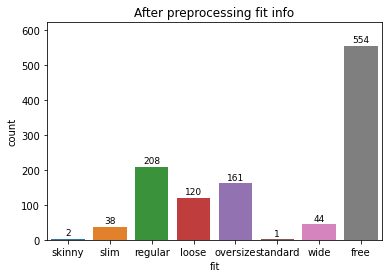

In [62]:
# -- bar 출력
print(len(item_fit['id'].unique()))

plt.title('After preprocessing fit info')
ax = sns.countplot(x='fit', data=item_fit, order=['스키니', '슬림', '레귤러', '루즈', '오버 사이즈', '스탠다드핏', '와이드', '프리'])
ax.set_xticklabels(['skinny', 'slim', 'regular', 'loose', 'oversize', 'standard', 'wide', 'free'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 10, height, ha = 'center', size = 9)
ax.set_ylim(0, ax.get_ylim()[1]+40)
plt.ylabel('count')
plt.show()

# 조회수

In [18]:
print(f'조회수 결측 데이터 수:', len(item[item['view'].isnull()]))

조회수 결측 데이터 수: 123


In [24]:
def preprocessing_view_info(view_info):
    '''
    view_info 데이터를 실수로 변환 및 전처리
    : view_info - 하나의 item에 대한 view 정보 (str or nan)
    '''
    if type(view_info) == str:
        view_info = view_info.replace('회 이상', '').strip()
        if view_info[-1] == '천':
            return float(view_info[:-1])*1000
        elif view_info[-1] == '만':
            return float(view_info[:-1])*10000
        return float(view_info)
    return view_info

# -- 데이터 초기화 (나중에 제거)
item = get_item_data('item')

# -- view 데이터 전처리
item['view'] = item.view.transform(preprocessing_view_info)

In [25]:
item['view'].head()

0       300.0
1     11000.0
2    110000.0
3       700.0
4     23000.0
Name: view, dtype: float64

# 누적판매

In [22]:
print(f'누적 판매 결측 데이터 수:', len(item[item['cum_sale'].isnull()]))

누적 판매 결측 데이터 수: 313


In [20]:
def preprocessing_cum_sale_info(cum_sale_info):
    '''
    cum_sale_info 데이터를 실수로 변환 및 전처리
    : cum_sale_info - 하나의 item에 대한 view 정보 (str or nan)
    '''
    #print(cum_sale_info)
    if type(cum_sale_info) == str:
        cum_sale_info = cum_sale_info.replace('개 이상', '').strip()
        cum_sale_info = cum_sale_info.replace('개 미만', '').strip()
        if cum_sale_info[-1] == '천':
            return float(cum_sale_info[:-1])*1000
        elif cum_sale_info[-1] == '만':
            return float(cum_sale_info[:-1])*10000
        return float(cum_sale_info)
    return cum_sale_info


# -- 데이터 초기화 (나중에 제거)
item = get_item_data('item')

# -- cum_sale 데이터 전처리
item['cum_sale'] = item.cum_sale.transform(preprocessing_cum_sale_info)
#item['cum_sale'].unique()

In [23]:
item['cum_sale'].head()

0        NaN
1     1400.0
2    25000.0
3        NaN
4    77000.0
Name: cum_sale, dtype: float64